# Проект "Событийный анализ стартапа по продаже продуктов"

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Требуется:
1. Изучить воронку продаж.

2. Исследовать результаты A/A/B-эксперимента. Дизайнеры предложили поменять шрифты во всём приложениии, было решено провести A/A/B-тест. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, не ухудшилось ли отношение пользователей к приложению после смены шрифтов.


**Данные**

Данные представлены одним файлом, содержащим лог действий пользователей в приложении за определённый временной промежуток - **logs_exp.csv**.

**Описание данных**

**EventName** — название события;

**DeviceIDHash** — уникальный идентификатор пользователя;

**EventTimestamp** — время события;

**ExpId** — номер эксперимента: 246 и 247 — контрольные группы, 248 — экспериментальная.

**План работы над проектом**

1. Загрузить и данные и выполнить предобработку. При необходимости изменить или дополнить представление данных, типы данных. Обработать пропуски и дубликаты.

2. Провести исследовательский анализ.
  1. Изучить данные и проверить их на наличие аномалий и ошибок.
  2. Изучить воронку событий приложения и конверсию каждого этапа событий.

3. Провести статистический анализ данных.
  1. Определить необходимые методы статистического анализа. Выбрать необходимый уровень статистической значимости для проведения теста.
  2. Подготовить данные.
  3. Провести необходимые тесты.
    1. Сравнить контрольные группы 246 и 247 для проверки корректности теста.
    2. Сравнить экспериментальную группу 248 с каждой из контрольных групп.
    3. Сравнить экспериментальную группу 248 с объединённой выборкой из двух контрольных групп.
4. Сделать общий вывод и сформулировать рекомендации.    



## Загрузка и предобработка данных



### Загрузка данных

In [1]:
#импорт необходимых библиотек
import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

import numpy as np

import math

from scipy import stats as st

from datetime import datetime as dt

#настройка ширины отображаемых колонок
pd.set_option('max_colwidth', 120)

#отключение текстовых предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка данных
data = pd.read_csv('logs_exp.csv', sep='\t')

#вывод первых строк датафрейма
display(data.head(20))

#основная информация о датафрейме
data.info()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Данные отображаются корректно. В качестве разделителя в датасете используется "\t".

На этапе предобработки необходимо:

 - переименовать столбцы и привести их названия к стилю snake_case;
 - привести значения даты и времени события (столбец **EventTimestamp**) к типу pandas datetime;
 - добавить отдельный столбец дат.

Пропусков нет.

### Предобработка данных



#### Переименование столбцов

In [3]:
data.columns = ['event_type','user_id','event_time','exp_id']

#### Приведение значений даты и времени к типу данных pandas и добавление отдельного столбца дат

In [4]:
#приведение значений сдаты и времени к типу данных pandas
data['event_time'] = data['event_time'].map(lambda x: dt.fromtimestamp(x))

#добавление отдельного столбца дат
data['dt'] = data['event_time'].dt.date

#вывод первых строк датафрейма
display(data.head(20))

#основная информация о датафрейме
data.info()

,event_type,user_id,event_time,exp_id,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   exp_id      244126 non-null  int64         
 4   dt          244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


#### Обработка дубликатов

In [5]:
f'Количество дубликатов сток в датафрейме: {data.duplicated().sum()}'

'Количество дубликатов сток в датафрейме: 413'

In [6]:
#удаление дубликатов
data = data.drop_duplicates()

### Вывод по разделу подготовки данных

Данные загружены, названия столбцов переименованы и приведены к стилю snake_case. Столбец, содержащий даты, приведён к типу данных pandas datetime. Добавлен столбец с датами.

Удалены 413 дублирующихся строк.

## Исследовательский анализ данных





### Изучение данных и проверка их на наличие аномалий и ошибок

#### Количество событий, пользователей и их соотношение

In [7]:
display(
    f'Типы событий: {data["event_type"].unique()}',
    f'Общее количество событий: {len(data["event_type"])}',
    f'Количество пользователей: {data["user_id"].nunique()}',
    f'Среднее количество событий на пользователя:',
    f'{data.groupby("user_id")["event_type"].agg("count").mean():.2f}'
)


"Типы событий: ['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'\n 'OffersScreenAppear' 'Tutorial']"

'Общее количество событий: 243713'

'Количество пользователей: 7551'

'Среднее количество событий на пользователя:'

'32.28'

Изучим показатель количества событий на пользователя более подробно: оценим характер распределения этого значения, выведем его основные характеристики и гистограмму распределения значений.

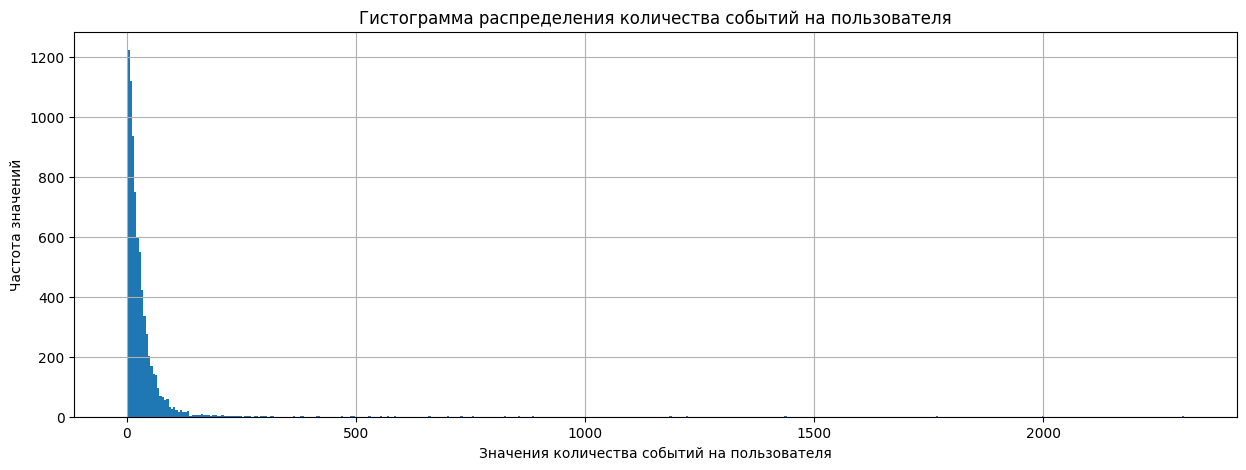

,events
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


In [8]:
events_by_users = data.pivot_table(index='user_id', values='event_type', aggfunc='count')
events_by_users.columns = ['events']

events_by_users['events'].hist(
    bins=460,
    figsize=(15,5)
)

plt.title('Гистограмма распределения количества событий на пользователя')
plt.xlabel('Значения количества событий на пользователя')
plt.ylabel('Частота значений')
plt.show()
events_by_users.describe()

Медианное значение 20, что сильно отличается от среднего, стандартное отклонение 65, что при среднем в 32 говорит о большом разбросе значений.

Минимальное значение 1, максимальное 2307. Основное количество значений сосредоточено между 1 и 79 (верхнаяя граница выбросов, равная Q3 + 1,5 * IQR). на гистограмме виден "хвост" из редких, но больших значений.

Построим гистограмму, отбросив "хвост" из аномально больших значений.

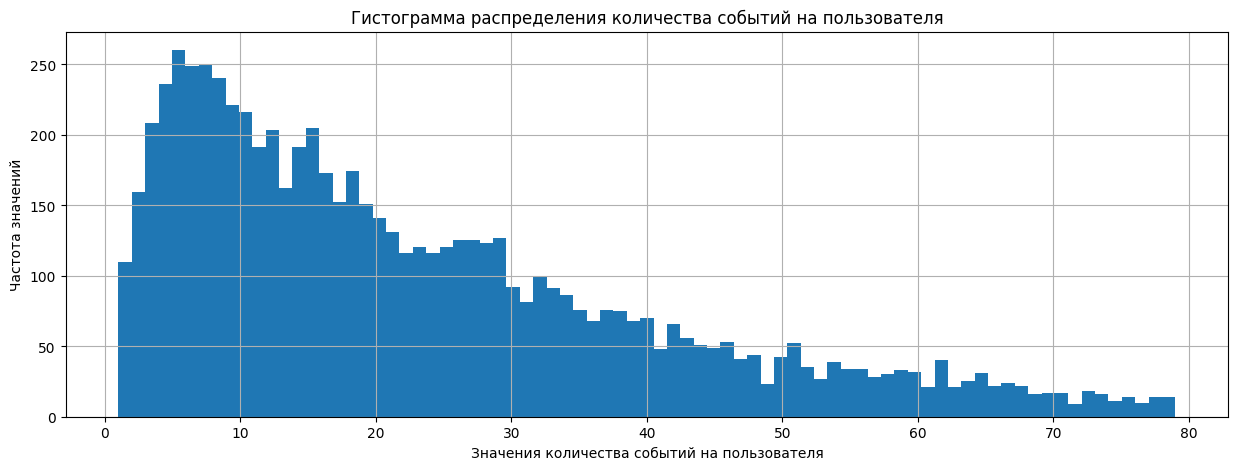

,events
count,7043.000000
mean,22.906858
std,17.719600
min,1.000000
25%,9.000000
50%,18.000000
75%,33.000000
max,78.000000


In [9]:
events_by_users.query('events <= 79')['events'].hist(
    bins=79,
    figsize=(15,5)
)

plt.title('Гистограмма распределения количества событий на пользователя')
plt.xlabel('Значения количества событий на пользователя')
plt.ylabel('Частота значений')

plt.show()
events_by_users.query('events < 79').describe()


Гистограмма выглядит характерно для биноминального распределения с малой вероятностью события относительно количества попыток.

Редкие большие значения, выглядящие аномальными, скорее всего, говорят о самых активных пользователях, которые тратят много времени в приложении, и аномалиями не являются.

#### Период, данные за который содержит датасет. Диаграмма количества событий по дате для разных групп

In [10]:
f'В логе содержатся данные с {data["event_time"].min()} по {data["event_time"].max()}'

'В логе содержатся данные с 2019-07-25 04:43:36 по 2019-08-07 21:15:17'

,dt,246,247,248
0,2019-07-25,4,1,4
1,2019-07-26,14,8,9
2,2019-07-27,24,23,8
3,2019-07-28,33,36,36
4,2019-07-29,55,58,71
5,2019-07-30,129,138,145
6,2019-07-31,620,664,746
7,2019-08-01,11561,12306,12274
8,2019-08-02,10946,10990,13618
9,2019-08-03,10575,11024,11683


<Figure size 1500x700 with 0 Axes>

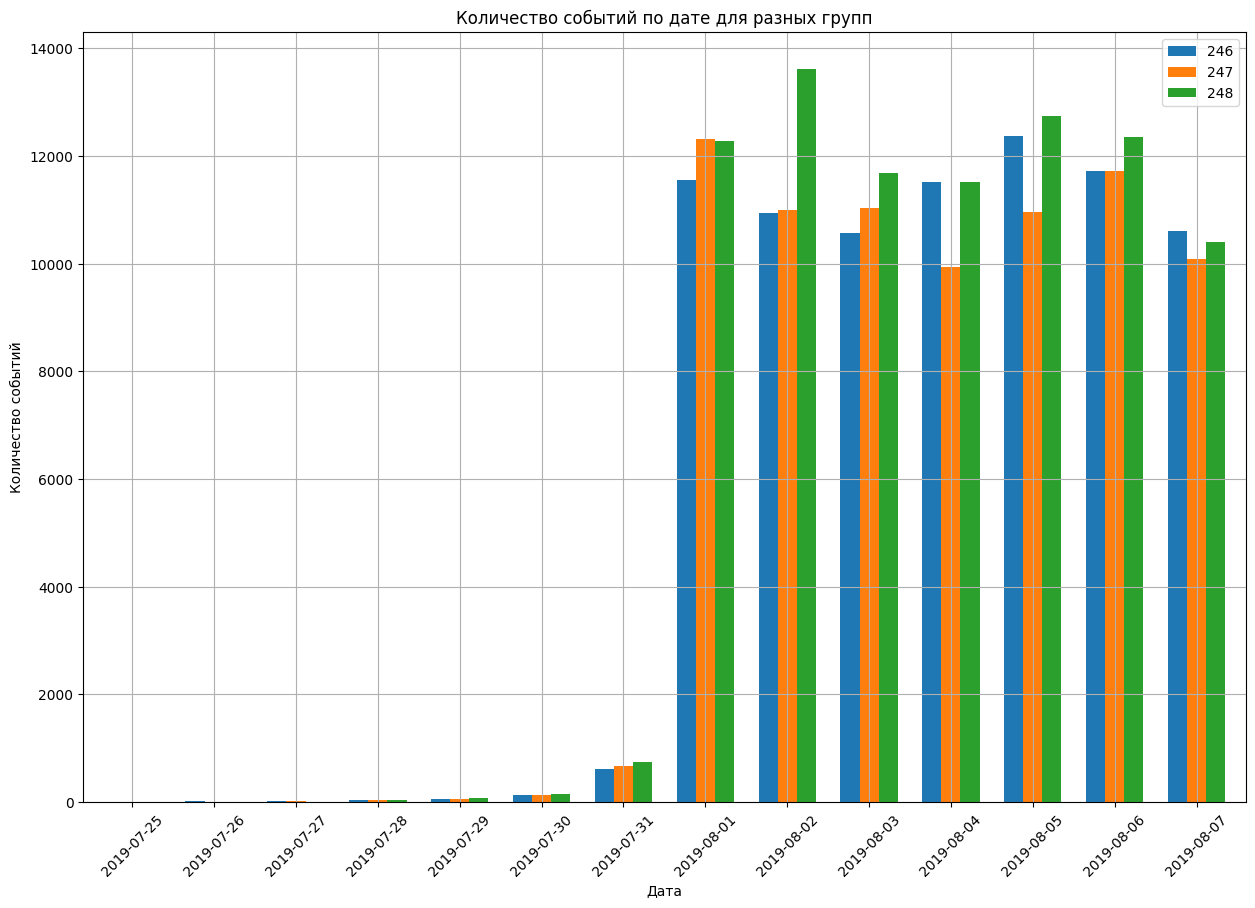

In [11]:
#таблица для построения диаграммы количества событий по дате для разных групп
events_date_groups = (
    data.pivot_table(
    index='dt',
    columns='exp_id',
    values='user_id',
    aggfunc='count'
).reset_index()
)

events_date_groups.columns=['dt','246','247','248']

display(events_date_groups)

#диаграмма
plt.figure(figsize=(15,7))
events_date_groups[['dt','246','247','248']].plot(
    x='dt',
    kind='bar',
    figsize=(15,10),
    width=0.7
)
plt.grid(True)
plt.title('Количество событий по дате для разных групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show();


Количество событий за день до 1 августа исчезающе мало. Очевидно, данные в логе за этот перод неполны. Полные данные есть только за период с 1 по 7 августа.

Создадим датафрейм с данными за этот период.

In [12]:
#датафрейм с данными с 1 по 7 августа 2019 г.
data_actual = data[data["dt"] >= pd.to_datetime('2019-08-01')]

#первые 20 строк
data_actual.head(20)

,event_type,user_id,event_time,exp_id,dt
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2833,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01
2834,OffersScreenAppear,3737462046622621720,2019-08-01 00:10:26,246,2019-08-01
2835,MainScreenAppear,3737462046622621720,2019-08-01 00:10:47,246,2019-08-01
2836,MainScreenAppear,3737462046622621720,2019-08-01 00:11:10,246,2019-08-01
2837,MainScreenAppear,3737462046622621720,2019-08-01 00:11:20,246,2019-08-01


Подсчёт количества потерянных при удалении неполных данных.

In [13]:
display(
    f'Количество удалённых событий: {len(data["event_type"]) - len(data_actual["event_type"])} из {len(data["event_type"])}',
    f'Процент удалённых событий: {(len(data["event_type"]) - len(data_actual["event_type"])) * 100 / len(data["event_type"]):.2f}',
    f'Количество удалённых пользователей: {data["user_id"].nunique() - data_actual["user_id"].nunique()} из {data["user_id"].nunique()}',
    f'Процент удалённых пользователей: {(data["user_id"].nunique() - data_actual["user_id"].nunique()) * 100 / data["user_id"].nunique():.2f}'
)


'Количество удалённых событий: 2826 из 243713'

'Процент удалённых событий: 1.16'

'Количество удалённых пользователей: 17 из 7551'

'Процент удалённых пользователей: 0.23'

Потери данных незначительные.

#### Количество и соотношение пользователей из разных групп

,users
group,
246,2484
247,2513
248,2537


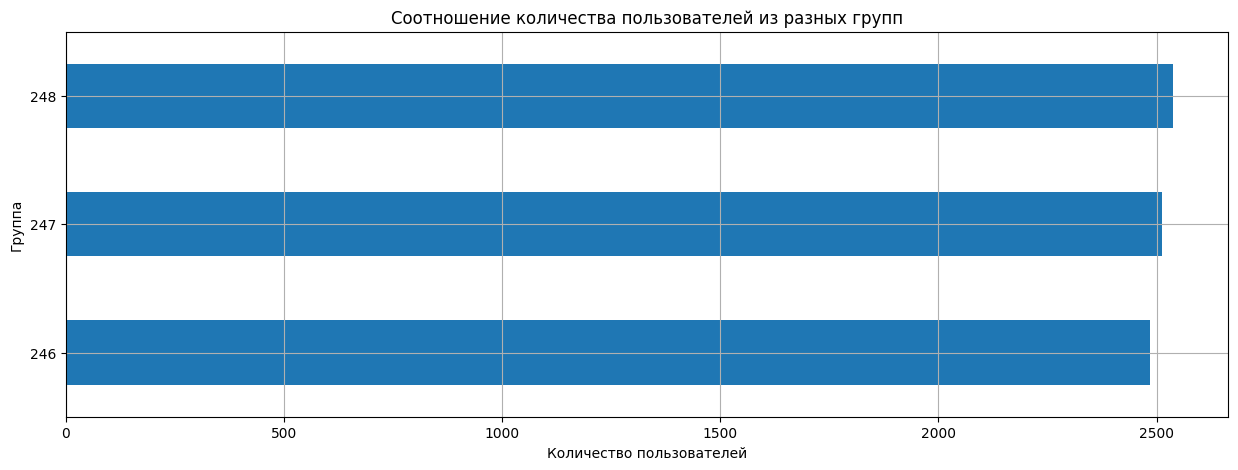

In [14]:
#сводная таблица
users_per_group = data_actual.pivot_table(
    index='exp_id',
    values='user_id',
    aggfunc=pd.Series.nunique
).reset_index()


users_per_group.columns = ['group', 'users']
users_per_group = users_per_group.set_index('group')

display(users_per_group)

#диаграмма

users_per_group.plot(
    kind='barh',
    grid=True,
    figsize=(15,5),
    legend=False
)
plt.title('Соотношение количества пользователей из разных групп')
plt.ylabel('Группа')
plt.xlabel('Количество пользователей')

plt.show();


Пользователи распределены по группам достаточно равномерно.

Проверим данные на наличие пользователей, попавших в несколько в разных групп.

In [15]:
users_diff_groups = (
    data_actual
    .groupby(
        'user_id', as_index=False
    )['exp_id']
    .agg('nunique')
    .query('exp_id > 1')['user_id']
)

display(
    f'Количество пользователей, попавших в неколько групп: {users_diff_groups.nunique()}'
)


'Количество пользователей, попавших в неколько групп: 0'

Пользователей, попавших одновременно в несколько  разных груп, нет. Система разбиения трафика работает корректно.

### Исследование воронки событий



#### Типы событий и частота их появления в логе

event_type
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: user_id, dtype: int64

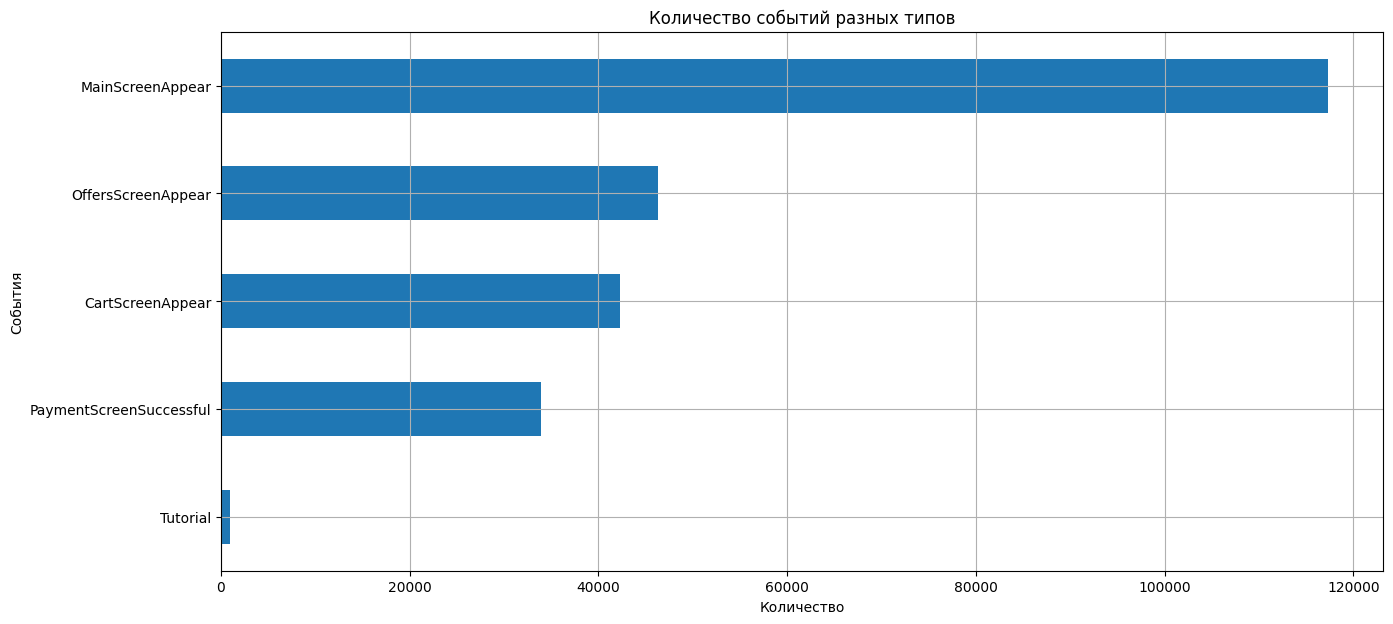

In [16]:
#таблица количества событий по типам
events_counts = (
    data_actual
        .groupby('event_type')['user_id']
        .agg('count')
        .sort_values(ascending=False)
)

#вывод таблицы
display(events_counts)

#диаграмма количества событий по типам
events_counts.sort_values().plot(
    kind='barh',
    grid=True,
    figsize=(15,7),
    legend=False
)
plt.title('Количество событий разных типов')
plt.ylabel('События')
plt.xlabel('Количество')
plt.show();

В логе события 5 видов:

- **"MainScreenAppear"** - пользователь заходит на главную страницу;
- **"OffersScreenAppear"** - пользователю предложены товары;
- **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами;
- **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары;
- **"Tutorial"** - пользователь перешёл на страницу с руководством.




#### Соотношение событий разного типа и пользователей. Воронка событий

In [17]:
#таблица количества пользователей по типам событий
users_per_event_type = (
    data_actual
        .groupby('event_type', as_index=False)['user_id']
        .agg('nunique')
        .sort_values(by='user_id', ascending=False)
).reset_index(drop=True)

users_per_event_type.columns=['event_type', 'users']

#количество пользователей в логе
users_count = data_actual['user_id'].nunique()

#доля пользователей, совершавших события разных типов

users_per_event_type['users_share'] = round(
        users_per_event_type['users'] * 100 / users_count, 2
        )


#вывод таблицы
users_per_event_type

,event_type,users,users_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


По-видимому, воронка событий выглядит следующим образом:

1. **"MainScreenAppear"** - пользователь заходит на главную страницу;

2. **"OffersScreenAppear"** - пользователю предложены товары, формирование заказа;

3. **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами;

4. **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары;


#### Конверсия воронки событий и её отдельных этапов

In [18]:
#конверсия  каждого отдельного этапа воронки в процентах

users_per_event_type['step_conversion'] = (round(
    users_per_event_type['users'] * 100 / users_per_event_type['users'].shift(1),
    2)
).fillna(users_per_event_type.loc[0]['users_share'])


display(users_per_event_type)

#конверсия от первого события до оплаты
conversion = (
    users_per_event_type.loc[3]['users'] * 100
    /
    users_per_event_type.loc[0]['users']
    )

display(
    f'Конверсия от первого события до успешной оплаты: {conversion:.2f} %'
)

#график конверсии каждого следующего шага

fig = px.funnel(
    users_per_event_type, x='step_conversion', y='event_type',
    title='Конверсия каждого следующего шага воронки событий',
    labels = {
        'step_conversion':'Конверсия, %',
        'event_type':'Событие '
    },
    width=1300,
    height=500
)
fig.show()




,event_type,users,users_share,step_conversion
0,MainScreenAppear,7419,98.47,98.47
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78
4,Tutorial,840,11.15,23.74


'Конверсия от первого события до успешной оплаты: 47.70 %'

47,7%  пользователей проходят от первого события до успешной оплаты заказа. Больше всего пользоветелей теряется на этапе **"OffersScreenAppear"** - предложения товаров и формирования заказа: 38,1 % пользователей, открывших прилоежение и посетивших главную страницу, не переходят к следующему этапу.

### Вывод по разделу исследовательского анализа данных

Полные данные в логе есть только за период с 1 по 7 августа.

Количество пользователей за этот период:

- общее: 7534;
- группа 246: 2484;
- группа 247: 2513;
- группа 248: 2537.

В логе события 5 видов:

- **"MainScreenAppear"** - пользователь заходит на главную страницу;
- **"OffersScreenAppear"** - пользователю предложены товары;
- **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами;
- **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары;
- **"Tutorial"** - пользователь перешёл на страницу с руководством.

Воронка событий выглядит следующим образом:

1. **"MainScreenAppear"** - пользователь заходит на главную страницу - совершают 98,47% пользователей, зашедших в приложение;

2. **"OffersScreenAppear"** - пользователю предложены товары, формирование заказа - совершают 61,91% пользователей, открывших главную страницу;

3. **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами - совершают 81,3% пользователей, выбравших товары;

4. **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары - совершают 94,78% пользователей, оформивших заказ в корзине;

47,7%  пользователей проходят от первого события до успешной оплаты заказа.

Больше всего пользоветелей теряется на этапе **"OffersScreenAppear"** - предложения товаров и формирования заказа: 38,1 % пользователей, открывших прилоежение и посетивших главную страницу, не переходят к следующему этапу.

## Статистический анализ данных



### Выбор теста для проверки гипотез

В данном исследования будут проверены гипотезы о равенстве значений конверсии для разных групп на разных этапах продуктовой воронки. Для проверки таких параметров хорошо подходит **z-тест**, поскольку для его проведения необходимо, чтобы исследуемая величина была распределена нормально с известным стандартным отклонением; при проверке гипотезы о равенстве конверсий измеряемой статистикой будет разница между пропорциями, т.е. величина, которая распределена нормально, а стандартное отклонение поддаётся вычислению.



### Расчёт уровня статистической значимости

Примем уровень статистической значимости в рамках исследования 5%. Поскольку исследование проводилось одновременно на трёх разных группах, для каждого параметра будет проведено четыре сравнения:

- сравнение параметра для двух контрольных групп (246 и 247);
- сравнение параметра для тестовой группы 248 и контрольной группы 246;
- сравнение параметра для тестовой группы 248 и контрольной группы 247;
- сравнение параметра для тестовой группы 248 и объединённой контрольной группы;

Следовательно, необходимо скорректировать уровень статистической значимости для каждой пары сравниваемых групп.

Воспользуемся для этого методом Шидака.

In [19]:
#общий уровень статистической значимости
alpha_full = 0.05

#количество сравнений
m = 4

#уровень статистической значимости для каждого отдельного сравнения
alpha =1 - (1 - alpha_full)**(1 / m)

f'Уровень статистической значимости для каждого попарного сравнения: {alpha}'

'Уровень статистической значимости для каждого попарного сравнения: 0.012741455098566168'

### Подготовка данных для проведения тестов

In [20]:
#список индексов-событий
df_stat = users_per_event_type.drop(
    ['users','users_share','step_conversion'],
    axis=1
    )

#добавление столбцов с количеством пользователей на событие
#и их доли от общего количества пользователей для каждой группы
for grp in sorted(data_actual['exp_id'].unique()):
    group_data = (
        data_actual[data_actual['exp_id'] == grp]
        .groupby('event_type', as_index=False)
        .agg({'user_id':'nunique'})
    )
    group_data['conversion'] = (
        group_data['user_id'] / users_per_group['users'][grp]
        )
    df_stat = df_stat.merge(
        group_data,
        left_on='event_type',
        right_on='event_type',
        how='left'
    )



#добавление данных объединённой контрольной группы
df_stat['user_246_247'] = df_stat['user_id_x'] + df_stat['user_id']
df_stat['conversion_246_247'] = (
    df_stat['user_246_247']
    /
     users_per_group['users'][246] + users_per_group['users'][247]
    )

df_stat = df_stat.set_index('event_type').T

#формирование мультииндекса

index = pd.MultiIndex.from_product(
    [[246,247,248,'246_247'],
     ['users','conversion']],
    names=['group', 'parameter']
    )

df_stat.index = index
df_stat = df_stat.T


#список событий для проверки
events_to_test = df_stat.index

users_in_groups = users_per_group['users']

#вывод результата
display('Таблица количества пользователей на событие и их доли от общего количества пользователей для каждой группы',
        df_stat,
        'Количество пользователей в группах',
        #users_per_group,
        users_in_groups,
        'Список событий для тестирования',
        events_to_test)


'Таблица количества пользователей на событие и их доли от общего количества пользователей для каждой группы'

group                       246                247                248  \
parameter                 users conversion   users conversion   users   
event_type                                                              
MainScreenAppear         2450.0   0.986312  2476.0   0.985277  2493.0   
OffersScreenAppear       1542.0   0.620773  1520.0   0.604855  1531.0   
CartScreenAppear         1266.0   0.509662  1238.0   0.492638  1230.0   
PaymentScreenSuccessful  1200.0   0.483092  1158.0   0.460804  1181.0   
Tutorial                  278.0   0.111916   283.0   0.112614   279.0   

group                              246_247               
parameter               conversion   users   conversion  
event_type                                               
MainScreenAppear          0.982657  4943.0  2514.989936  
OffersScreenAppear        0.603469  3073.0  2514.237118  
CartScreenAppear          0.484825  2496.0  2514.004831  
PaymentScreenSuccessful   0.465510  2381.0  2513.958535  
Tutorial                  0.109972   557.0  2513.224235

'Количество пользователей в группах'

group
246    2484
247    2513
248    2537
Name: users, dtype: int64

'Список событий для тестирования'

Index(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'],
      dtype='object', name='event_type')

### Функция для проверки гипотезы о равенстве долей пользователей, совершивших событие

In [21]:
#функция
def z_test(df, group_1, group_2, event, users_1, users_2):
    try:
        #конверсия группы 1
        p1 = df[group_1,'conversion'][event]

        #конверсия группы 2
        p2 = df[group_2,'conversion'][event]

        #конверсия скомбинированной выборки
        p_combined = (
            df[group_1, 'users'][event]
            +
            df[group_2, 'users'][event]
        ) / (users_1 + users_2)

        #разница между конверсиями
        difference = p1 - p2

        #z-значение
        z_score = (
            difference
            /
            math.sqrt(p_combined * (1 - p_combined) * (1/users_1 + 1/users_2))
            )

        #построение стандартного нормального распределения
        distr = st.norm(0, 1)

        #вычисление p-value
        p_value = (1 - distr.cdf(abs(z_score))) * 2

        return [z_score, p_value]

    except:

        display('Ошибка работы функции')


### Проверка гипотезы о равенстве долей пользователей, совершивших разные события, между контрольными группами 246 и 247

Формулирование гипотез.

Нулевая гипотеза: доли пользователей из групп **246** и **247**, совершивших, события, одинаковы.

Алтернативная гипотеза: доли пользователей из групп **246** и **247**, совершивших, события, различаются.

In [22]:
test_group_1 = 246
test_group_2 = 247

for ev in events_to_test:
    results = z_test(
        df_stat,
        test_group_1,
        test_group_2,
        ev,
        users_in_groups[test_group_1],
        users_in_groups[test_group_2]
        )
    print(f'''
Результат теста для события "{ev}":

z-score: {results[0]}
p-value: {results[1]}
    ''')
    if results[1] < alpha:
        print('Отвергаем нулевую гипотезу \n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу \n')




Результат теста для события "MainScreenAppear":

z-score: 0.3093441851418436
p-value: 0.7570597232046099
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "OffersScreenAppear":

z-score: 1.154987713610383
p-value: 0.2480954578522181
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "CartScreenAppear":

z-score: 1.203368576486285
p-value: 0.22883372237997213
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "PaymentScreenSuccessful":

z-score: 1.5779948491596598
p-value: 0.11456679313141849
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "Tutorial":

z-score: -0.0781614596617372
p-value: 0.9376996189257114
    
Не получилось отвергнуть нулевую гипотезу 



Результат проверки между двумя контрольными группами показывает, что система разбиения трафика работает корректно, расчёты выполняются правильно: для всех событий разница между долей пользователей совершивших событие, не является статистически значимой.

### Проверка гипотезы о равенстве долей пользователей, совершивших разные события, между группами 246 (контрольная) и 248 (тестовая)

Формулирование гипотез.

Нулевая гипотеза: доли пользователей из групп **246** и **248**, совершивших, события, одинаковы.

Алтернативная гипотеза: доли пользователей из групп **246** и **248**, совершивших, события, различаются.

In [23]:
test_group_1 = 246
test_group_2 = 248

for ev in events_to_test:
    results = z_test(
        df_stat,
        test_group_1,
        test_group_2, ev,
        users_in_groups[test_group_1],
        users_in_groups[test_group_2]
        )
    print(f'''
Результат теста для события "{ev}":

z-score: {results[0]}
p-value: {results[1]}
    ''')
    if results[1] < alpha:
        print('Отвергаем нулевую гипотезу \n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу \n')



Результат теста для события "MainScreenAppear":

z-score: 1.0472762353383693
p-value: 0.2949721933554552
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "OffersScreenAppear":

z-score: 1.2580821335711887
p-value: 0.20836205402738917
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "CartScreenAppear":

z-score: 1.7598736474548398
p-value: 0.07842923237520116
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "PaymentScreenSuccessful":

z-score: 1.2473878277158326
p-value: 0.2122553275697796
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "Tutorial":

z-score: 0.21928326020412683
p-value: 0.8264294010087645
    
Не получилось отвергнуть нулевую гипотезу 



При сравнении тестовой группы **248** с контрольной группой **246** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

### Проверка гипотезы о равенстве долей пользователей, совершивших разные события, между группами 247 (контрольная) и 248 (тестовая)

Формулирование гипотез.

Нулевая гипотеза: доли пользователей из групп **247** и **248**, совершивших, события, одинаковы.

Алтернативная гипотеза: доли пользователей из групп **247** и **248**, совершивших, события, различаются.

In [24]:
test_group_1 = 247
test_group_2 = 248

for ev in events_to_test:
    results = z_test(
        df_stat,
        test_group_1,
        test_group_2,
        ev,
        users_in_groups[test_group_1],
        users_in_groups[test_group_2]
        )
    print(f'''
Результат теста для события "{ev}":

z-score: {results[0]}
p-value: {results[1]}
    ''')
    if results[1] < alpha:
        print('Отвергаем нулевую гипотезу \n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу \n')



Результат теста для события "MainScreenAppear":

z-score: 0.740980338642352
p-value: 0.4587053616621515
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "OffersScreenAppear":

z-score: 0.1007086015299871
p-value: 0.9197817830592261
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "CartScreenAppear":

z-score: 0.5554019078073092
p-value: 0.5786197879539783
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "PaymentScreenSuccessful":

z-score: -0.3353759529753951
p-value: 0.7373415053803964
    
Не получилось отвергнуть нулевую гипотезу 


Результат теста для события "Tutorial":

z-score: 0.2984969253006019
p-value: 0.765323922474501
    
Не получилось отвергнуть нулевую гипотезу 



При сравнении тестовой группы **248** с контрольной группой **247** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

### Проверка гипотезы о равенстве долей пользователей, совершивших разные события, между объединённой контрольной группой (246 и 247) и 248 (тестовая)

Формулирование гипотез.

Нулевая гипотеза: доли пользователей из объединённой контрольной группы (**246** + **247**) и тестовой группой **248**, совершивших, события, одинаковы.

Алтернативная гипотеза: доли пользователей из из объединённой контрольной группы (**246** + **247**) и тестовой группой **248**, совершивших, события, различаются.

In [25]:
test_group_1 = '246_247'
test_group_2 = 248

for ev in events_to_test:
    results = z_test(
        df_stat,
        test_group_1,
        test_group_2,
        ev,
        users_in_groups[246] + users_in_groups[247],
        users_in_groups[test_group_2]
        )
    print(f'''
Результат теста для события "{ev}":

z-score: {results[0]}
p-value: {results[1]}
    ''')
    if results[1] < alpha:
        print('Отвергаем нулевую гипотезу \n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу \n')



Результат теста для события "MainScreenAppear":

z-score: 910146.9512414696
p-value: 0.0
    
Отвергаем нулевую гипотезу 


Результат теста для события "OffersScreenAppear":

z-score: 211508.6971320309
p-value: 0.0
    
Отвергаем нулевую гипотезу 


Результат теста для события "CartScreenAppear":

z-score: 206224.45638760854
p-value: 0.0
    
Отвергаем нулевую гипотезу 


Результат теста для события "PaymentScreenSuccessful":

z-score: 206516.05630755404
p-value: 0.0
    
Отвергаем нулевую гипотезу 


Результат теста для события "Tutorial":

z-score: 328219.395188318
p-value: 0.0
    
Отвергаем нулевую гипотезу 



При сравнении тестовой группы **248** с объединённой контрольной группой (**246** + **247**) ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

### Вывод об уровне статистической значимости

Уровень статистической значимости, установленный на уровне 5%, привёл бы к другим результатам: тест для события **"MainScreenAppear"** при сравнении тестовой группы **248** с объединённой контрольной группой (**246** + **246**) показал p-value, равное 0.018.

Коррекция уровня статистической значимости по методу Шидака позволила провести тест более точно и избежать ложнопозитивного результата.

### Вывод по разделу статистического анализа данных

В данном исследования будут проверены гипотезы о равенстве значений конверсии для разных групп на разных этапах продуктовой воронки. Для проверки параметра используется **z-тест**.

Общий уровень статистической значимости в рамках исследования установлен в 5%. Поскольку в рамках исследования проводились 4 сравнения одновременно на трёх разных группах, уровень статистической значимости был скорректирован методом Шидака и установлен в 1,27%.

Результаты проведённых тестов:

Результат проверки между двумя контрольными группами**246** и **247** показывает, что система разбиения трафика работает корректно, расчёты выполняются правильно: для всех событий разница между долей пользователей совершивших событие, не является статистически значимой.

При сравнении тестовой группы **248** с контрольной группой **246** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

При сравнении тестовой группы **248** с контрольной группой **247** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

При сравнении тестовой группы **248** с объединённой контрольной группой (**246** + **247**) ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

## Общий вывод

### Цели и задачи проекта

Цели проекта:

Изучить воронку продаж приложения и проверить гипотезу об изменении отношения пользователей к приложению после смены шрифтов.

Задачи проекта:

1. Изучить данные:
    - определить действительный период, за который есть полные данные;
    - определить количество событи;, пользователей, их количество, соотношение и распределение пользователей по группам.

2. Изучить воронку продаж:
    - определить этапы воронки событий;
    - рассчитать конверсию каждого этапа;
    - выяснить, на каком этапе теряется больше всего пользователей.

3. Провести статистический анализ результатов A/A/B-эксперимента. Провести серию тестов для определения изменения доли пользователей, оказавшихся на разных этапах воронки событий приложения, для двух контрольных групп и одной тестовой, пользователи которой работали в приложении с изменёнными шрифтами.

### Исследовательский анализ данных

Полные данные в логе есть только за период с 1 по 7 августа.

Количество пользователей за этот период:

- общее: 7534;
- группа 246: 2484;
- группа 247: 2513;
- группа 248: 2537.

В логе события 5 видов:

- **"MainScreenAppear"** - пользователь заходит на главную страницу;
- **"OffersScreenAppear"** - пользователю предложены товары;
- **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами;
- **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары;
- **"Tutorial"** - пользователь перешёл на страницу с руководством.

Воронка событий выглядит следующим образом:

1. **"MainScreenAppear"** - пользователь заходит на главную страницу - совершают 98,47% пользователей, зашедших в приложение;

2. **"OffersScreenAppear"** - пользователю предложены товары, формирование заказа - совершают 61,91% пользователей, открывших главную страницу;

3. **"CartScreenAppear"** - пользователь перешёл в "корзину" с выбранными товарами - совершают 81,3% пользователей, выбравших товары;

4. **"PaymentScreenSuccessful"** - пользователь успешно оплатил товары - совершают 94,78% пользователей, оформивших заказ в корзине;

47,7%  пользователей проходят от первого события до успешной оплаты заказа.

Больше всего пользоветелей теряется на этапе **"OffersScreenAppear"** - предложения товаров и формирования заказа: 38,1 % пользователей, открывших прилоежение и посетивших главную страницу, не переходят к следующему этапу.

### Статистический анализ данных

В данном исследования будут проверены гипотезы о равенстве значений конверсии для разных групп на разных этапах продуктовой воронки. Для проверки параметра используется **z-тест**.

Общий уровень статистической значимости в рамках исследования установлен в 5%. Поскольку в рамках исследования проводились 4 сравнения одновременно на трёх разных группах, уровень статистической значимости был скорректирован методом Шидака и установлен в 1,27%.

Результаты проведённых тестов:

Результат проверки между двумя контрольными группами**246** и **247** показывает, что система разбиения трафика работает корректно, расчёты выполняются правильно: для всех событий разница между долей пользователей совершивших событие, не является статистически значимой.

При сравнении тестовой группы **248** с контрольной группой **246** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

При сравнении тестовой группы **248** с контрольной группой **247** ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

При сравнении тестовой группы **248** с объединённой контрольной группой (**246** + **247**) ни для одного из событий нет статистически значимой разницы в долях пользователей, совершивших событие.

### Рекомендации по результатам исследования

Рекомендую считать, что изменение шрифтов в приложении не повлияло на отношение пользователей к приложению и их конверсию ни для одного из этапов воронки событий приложения.

### О качестве данных

В датасете присутствуют 413 дублирующихся строк.

Пропусков данных и явных ошибок в датасетах нет.